# Importing Relevant Packages and Loading Data

In [1]:
!pip install rake-nltk

In [2]:


import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import time
import re
import numpy as np
import nltk
import seaborn as sns
import os
import csv
nltk.download('punkt')
nltk.download('stopwords')
from nltk import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
#from hcluster import pdist, linkage, dendrogram
from nltk.tokenize import RegexpTokenizer
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import pairwise_distances

import scipy.cluster.hierarchy as sch



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tyler\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tyler\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [3]:
# load the meta data from the CSV file 
df=pd.read_csv('metadata.csv', usecols=['title','abstract','authors','doi','publish_time'])
print (df.shape)

#drop duplicates
df = df.drop_duplicates(subset='abstract', keep="first")

#drop NANs 
df=df.dropna()

# convert abstracts and titles to lowercase
df["abstract"] = df["abstract"].str.lower()
df['title']=df['title'].str.lower()

#show 10 lines of the new dataframe
print (df.shape)
df.head(10)

(45774, 5)
(34809, 5)


,title,doi,abstract,publish_time,authors
0,siann: strain identification by alignment to n...,10.1101/001727,next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...
1,spatial epidemiology of networked metapopulati...,10.1101/003889,an emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li
2,sequencing of the human ig light chain loci fr...,10.1101/006866,germline variation at immunoglobulin gene (ig)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...
3,bayesian mixture analysis for metagenomic comm...,10.1101/007476,deep sequencing of clinical samples is now an ...,2014-07-25,Sofia Morfopoulou; Vincent Plagnol
4,mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen
5,the infant airway microbiome in health and dis...,10.1101/012070,the nasopharynx (np) is a reservoir for microb...,2014-12-02,Shu Mei Teo; Danny Mok; Kym Pham; Merci Kusel;...
6,using heterogeneity in the population structur...,10.1101/017178,"abstractin 2013, u.s. swine producers were con...",2015-03-27,Eamon B. O’Dea; Harry Snelson; Shweta Bansal
7,"big city, small world: density, contact rates,...",10.1101/018481,macroscopic descriptions of populations common...,2015-04-27,Moritz U. G. Kraemer; T. Alex Perkins; Derek A...
8,mers-cov recombination: implications about the...,10.1101/020834,recombination is a process that unlinks neighb...,2015-06-12,Gytis Dudas; Andrew Rambaut
9,on the causes of evolutionary transition:trans...,10.1101/027722,a pattern in which nucleotide transitions are ...,2015-09-28,Arlin Stoltzfus; Ryan W. Norris


Goal is to first sort the articles into which coronavirus is the topic of research in each article. A list of current coronaviruses was obtained from CDC website (https://www.cdc.gov/coronavirus/types.html) and incluw. CDC blocks display of website in Python so I had to screenshot the website.

# Data Cleaning

## Labelling papers by coronavirus type

To begin, I plan to label the papers based on the type of coronavirus that the paper is discussing. To do this, I first had to obtain a list of known coronavirus' from the CDC website. Following this, the abstracts were searched to find matches for each coronavirus used as a key word. As there is no quick way of determining which virus is the basis of the paper if multiple virus' are mentioned, those were simply labelled as "multi". The title did not provide enough matches to be used which is why the abstract was used. I understand this is not a perfect method as there could be a  multitude of false positives due to the papers basis' being about other virus' such as H1N1 and West Nile, but it should prove valid for the majority of papers.

Goal is to first sort the articles into which coronavirus is the topic of research in each article. A list of current coronaviruses was obtained from CDC website (https://www.cdc.gov/coronavirus/types.html) and incluw. CDC blocks display of website in Python so I had to screenshot the website.


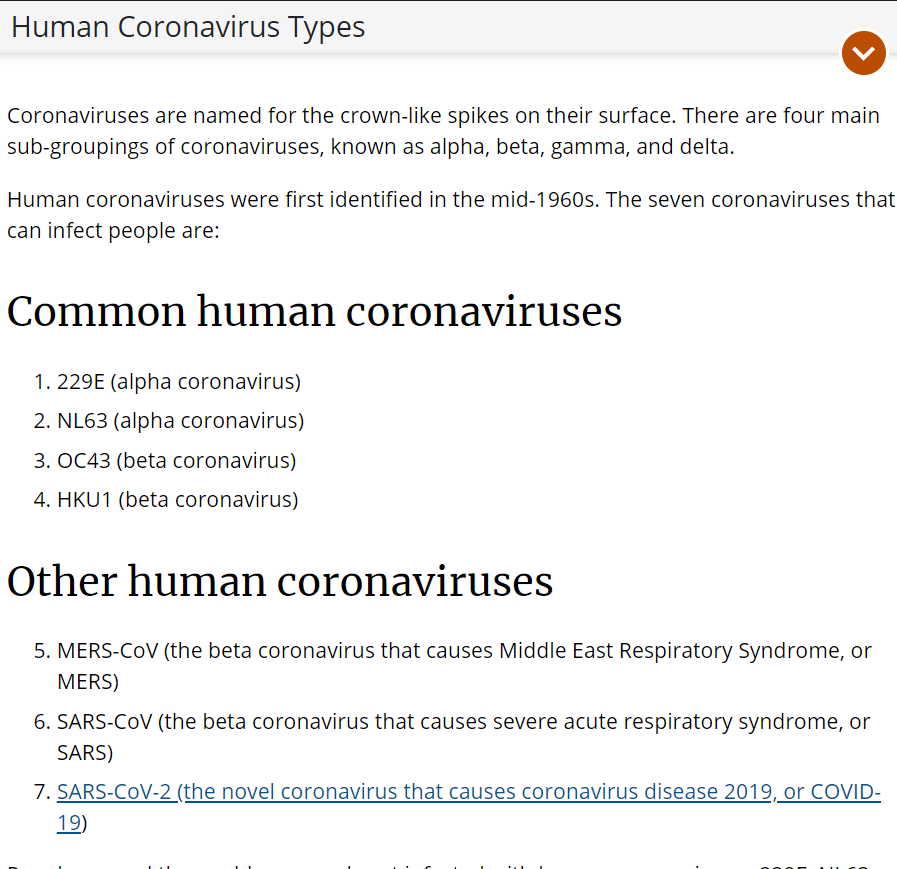

In [4]:
 #obtaining image from CDC website (they block displaying HTML)
from IPython.display import Image, HTML, display
display(Image('coronavirus_types.PNG'))

In [5]:
virus_list = '229e','nl63','oc43','hku1','mers-cov','mers','sars-cov','sars','sars-cov-2','covid-19'

In [6]:
virus=df

for v in virus_list:
    virus[v] = np.zeros(len(virus))
#reset_index
virus = virus.reset_index()
virus.head(5)

,index,title,doi,abstract,publish_time,authors,229e,nl63,oc43,hku1,mers-cov,mers,sars-cov,sars,sars-cov-2,covid-19
0,0,siann: strain identification by alignment to n...,10.1101/001727,next-generation sequencing is increasingly bei...,2014-01-10,Samuel Minot; Stephen D Turner; Krista L Ternu...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,spatial epidemiology of networked metapopulati...,10.1101/003889,an emerging disease is one infectious epidemic...,2014-06-04,Lin WANG; Xiang Li,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,sequencing of the human ig light chain loci fr...,10.1101/006866,germline variation at immunoglobulin gene (ig)...,2014-07-03,Corey T Watson; Karyn Meltz Steinberg; Tina A ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,bayesian mixture analysis for metagenomic comm...,10.1101/007476,deep sequencing of clinical samples is now an ...,2014-07-25,Sofia Morfopoulou; Vincent Plagnol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,mapping a viral phylogeny onto outbreak trees ...,10.1101/010389,developing methods to reconstruct transmission...,2014-11-11,Stephen P Velsko; Jonathan E Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
for i in range(len(virus)):    
    text = str(virus.iloc[i,3])    
    for sk in virus_list :        
        if any(x in sk for x in ['+']):
            skk = re.escape(sk)
        else:
            skk = sk
        result = re.search(r'(?:^|(?<=\s))' + skk + r'(?=\s|$)',text) 
        if result:
            virus[sk][i] = 1

C:\Users\Tyler\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [8]:
virus['sum'] = virus.iloc[:,7:16].sum(axis=1)
virus['sum'].head(20)

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     1.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
Name: sum, dtype: float64

In [9]:
virus = virus[virus['sum'] != 0]
virus=virus.reset_index(drop=True)

In [10]:
virus['virus_type']='blank'
for i in range(len(virus)):
    if virus['229e'][i] > 0:
        virus['virus_type'][i]='229e'
    elif virus['nl63'][i] > 0:
        virus['virus_type'][i]='nl63'
    elif virus['oc43'][i] > 0:
        virus['virus_type'][i]='oc43'
    elif virus['hku1'][i] > 0:
        virus['virus_type'][i]='hku1'
    elif virus['mers-cov'][i] > 0 or virus['mers'][i] > 0:
        virus['virus_type'][i]='mers'
    elif virus['sars-cov'][i] > 0 or virus['sars'][i] > 0:
        virus['virus_type'][i]='sars'
    elif virus['sars-cov-2'][i] > 0 or virus['covid-19'][i] > 0:
        virus['virus_type'][i]='covid'
        

C:\Users\Tyler\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\Tyler\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Tyler\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\Tyler\Anaconda3\lib\site-packages\ipyke

In [11]:
#virus.to_csv(r'C:\Users\Tyler\Documents\UofT\DS\Exam\looke.csv', index = False)

In [12]:
virus['virus_type']='blank'
#Labelling the papers based on key words of known coronavirus
for i in range(len(virus)):
    if virus['229e'][i] > 0 and virus['sum'][i] == 1:
        virus['virus_type'][i]='229e'        
    elif virus['nl63'][i] > 0 and virus['sum'][i] == 1:
        virus['virus_type'][i]='nl63'        
    elif virus['oc43'][i] > 0 and virus['sum'][i] == 1:
        virus['virus_type'][i]='oc43'
    elif virus['hku1'][i] > 0 and virus['sum'][i] == 1:
        virus['virus_type'][i]='hku1'
    elif virus['mers-cov'][i] > 0 and virus['sum'][i] == 1:
        virus['virus_type'][i]='mers'
    elif virus['mers'][i] > 0 and virus['sum'][i] == 1:
        virus['virus_type'][i]='mers'
    elif virus['sars-cov'][i] > 0 and virus['sum'][i] == 1: 
        virus['virus_type'][i]='sars'
    elif virus['sars'][i] > 0 and virus['sum'][i] == 1:
        virus['virus_type'][i]='sars'
    elif virus['sars-cov-2'][i] > 0 and virus['sum'][i] == 1:
        virus['virus_type'][i]='covid'
    elif virus['covid-19'][i] > 0 and virus['sum'][i] == 1:
        virus['virus_type'][i]='covid'
    else:
        virus['virus_type'][i]='multi'
#virus['virus_type'].unique()
virus = virus.reset_index()

C:\Users\Tyler\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\Tyler\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Tyler\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Tyler\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyW

In [13]:
virus['abstract'] = virus['title'] +' '+virus['abstract']

In [14]:
virus['abstract'].head(10)

0    mers-cov recombination: implications about the...
1    mers-cov spillover at the camel-human interfac...
2    mers-cov nsp16 necessary for ifn resistance an...
3    proofreading-deficient coronaviruses adapt ove...
4    complemented palindrome small rnas first disco...
5    ca2+ ions promote fusion of middle east respir...
6    genomic and protein structure modelling analys...
7    discovery of a novel coronavirus associated wi...
8    functional assessment of cell entry and recept...
9    preliminary estimation of the basic reproducti...
Name: abstract, dtype: object

# Exploratory Analysis

Below, a graph was created comparing the coronavirus of topic totals for the reearch paper dataset. As expected, most of the research papers  are about SARS. This makes sense as SARS was the most severe of the past coronavirus' (Not including Covid-19) and therefore would have the most published papers about it. Additionally, Covid i fairly recent so although researchers are racing to find out more, there is not as many papers published as of yet (evetually there will be more than SARS). Suprisingly, there is still a mutitude of Covid-19 papers out already which highlights the severity of the virus. It is also worth note that a large portion of papers mention multiple virus', however it will be extremely difficult for me to text mine these as I have limited knowledge of which symptoms pertain to which virus as the whole abstract is being analyzed without order.

Text(0.5, 1.0, 'Distribution of Coronavirus Type by Paper Count')

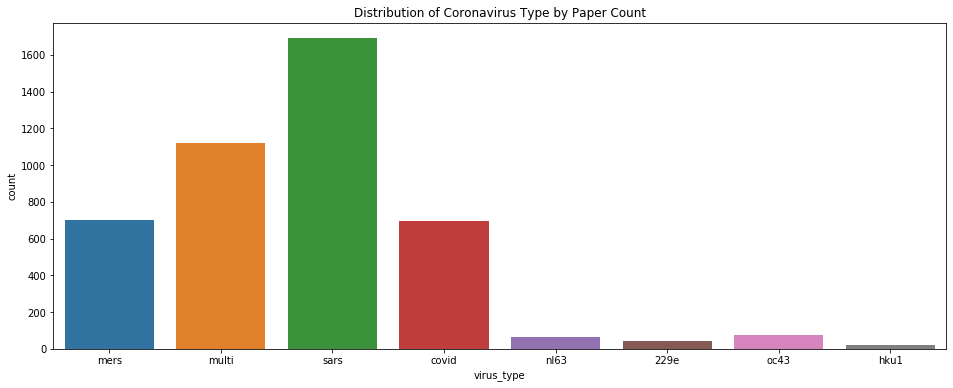

In [15]:
#Create barplot using seaborn
plt.figure(figsize=(16, 6))
sns.countplot(x='virus_type',data=virus).set_title('Distribution of Coronavirus Type by Paper Count')

Next, I want to see which symptoms pertain to each of the virus' seen above. To do this, a similar method will be used taking a list of common symptoms and obtaining a count for each virus.

In [16]:
symptom_list = [ 'fever', 'cough', 'rhinitis', 'throat', 'hoarseness', 'bronchitis', 'bronchiolitis', 'pneumonia', 'shortness']

In [17]:
for symp in symptom_list:
    virus[symp] = np.zeros(len(virus))
#reset_index
virus = virus.reset_index(drop=True)


In [18]:
  for i in range(len(virus)):    
    text = str(virus.iloc[i,4])    
    for sp in symptom_list :        
        if any(x in sp for x in ['+']):
            spp = re.escape(sp)
        else:
            spp = sp
        result = re.search(r'(?:^|(?<=\s))' + spp + r'(?=\s|$)',text) 
        if result:
            virus[sp][i] = 1

C:\Users\Tyler\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [19]:
virus.to_csv(r'C:\Users\Tyler\Documents\UofT\DS\Exam\looke.csv', index = False)

In [20]:
virus['sum_symp'] = virus.iloc[:,20:29].sum(axis=1)
totals=virus.iloc[:,20:29].sum(axis=0)
virus = virus[virus['sum_symp'] != 0]
virus=virus.reset_index(drop=True)

In [21]:
totals

cough             89.0
rhinitis           3.0
throat            55.0
hoarseness         0.0
bronchitis        31.0
bronchiolitis      9.0
pneumonia        357.0
shortness         37.0
sum_symp         581.0
dtype: float64

For the purpose of this analysis only the commonly seen symptoms will be analyzed. I will ommit rhinitis, hoarseness, and bronchiolitis for now.

In [22]:
#virus.iloc[:,16:28]

In [23]:
graphic=virus.iloc[:,18:28]
graphic=graphic.reset_index(drop=True)

fever_graphic = graphic[['fever', 'virus_type']].copy()
cough_graphic = graphic[['cough', 'virus_type']].copy()
throat_graphic = graphic[['throat', 'virus_type']].copy()
bronchitis_graphic =graphic[['bronchitis', 'virus_type']].copy()
pneumonia_graphic= graphic[['pneumonia', 'virus_type']].copy()

shortness_graphic = graphic[['shortness', 'virus_type']].copy()


In [24]:
cough_graphic

,cough,virus_type
0,0.0,sars
1,0.0,sars
2,0.0,mers
3,0.0,sars
4,0.0,sars
...,...,...
513,0.0,covid
514,0.0,multi
515,0.0,sars
516,0.0,multi


In the graph below the symptom "cough" is plotted where 0 means it was not mentioned as a symptom for the specific virus in the abstract, and 1 where it was in fact mentioned as a symtom of that specific virus in the abstract. On the Y axis the cummulative number of 1s and 0s for each virus . As the count of the number of available papers for each virus is different, it is important to compare the blue (not mentioned) to the red (mentioned) to see overall how often the symptom is mentioned in comparison to not being metnioned. It is important to note that only papers that contain at least 1 symptom were used, in order to filter out papers that are not concerned about virus symptoms which would skew the data. Although this is not a perfect method likely the symptoms with the highest symptom/no symptom ratio will be the most common or problematic for said virus. By looking at this data it can be seen that a cough is a symptom for most of the different viruses and appears just as frequently as the red to blue column ratio is very similar for mostly all the virus'. For the three main coronaviruses of concern (sars, mars and covid) the ratio is almost exactly the same.

Text(0.5, 1.0, 'Presence of cough in research paper absract +by coronavirus type')

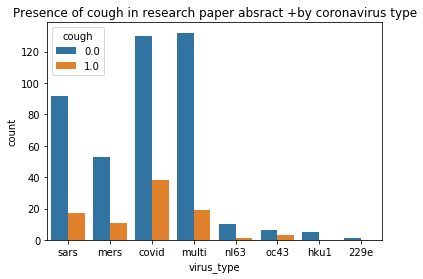

In [25]:
sns.countplot(x="virus_type", hue="cough", data=cough_graphic)
plt.title('Presence of cough in research paper absract +by coronavirus type')


(0, 100)

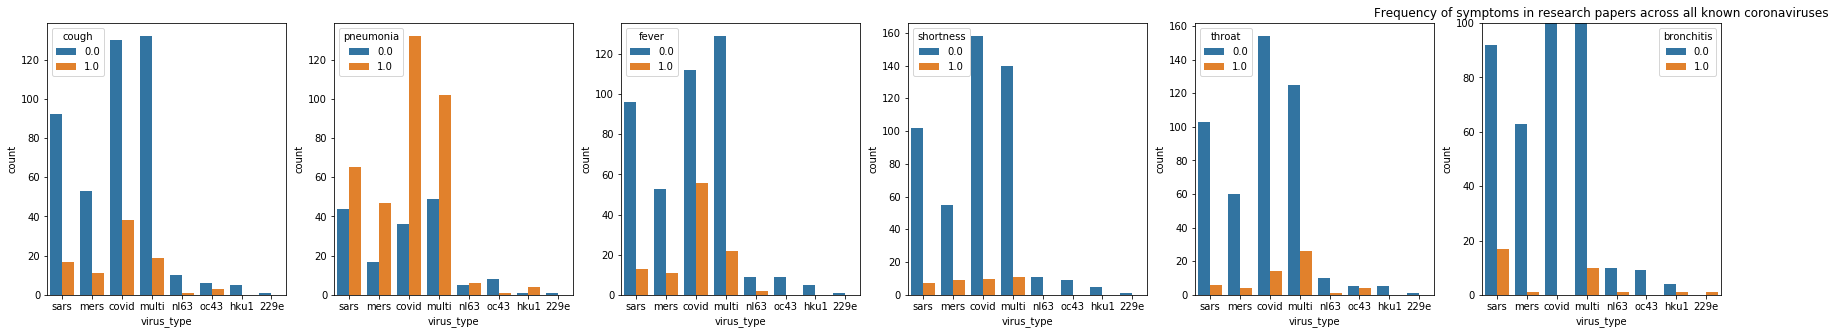

In [26]:
df_dims = (30, 5)

fig, axs = plt.subplots(ncols=6, figsize=df_dims)
sns.countplot(x='virus_type', hue='cough', data=cough_graphic, ax=axs[0])
sns.countplot(x='virus_type', hue= 'pneumonia',data=pneumonia_graphic, ax=axs[1])
sns.countplot(x='virus_type', hue='fever',data=fever_graphic, ax=axs[2])
plt.title('Frequency of symptoms in research papers across all known coronaviruses')
sns.countplot(x='virus_type', hue='shortness',data=shortness_graphic, ax=axs[3])
sns.countplot(x='virus_type', hue='throat',data=throat_graphic, ax=axs[4])
sns.countplot(x='virus_type', hue='bronchitis',data=bronchitis_graphic, ax=axs[5])

plt.ylim(0,100)


Above all of the major symptoms were plotted against the virus types using has symptom or does not have symptom as the hue argument . For the three main viruses it can be seen that pneumonia is talked about in more articles than it is not (remember all articles in this study have at least one symptom mentioned). It is the only symptom that is mentioned more than not. most likely this is because some of the other symptoms can be considered more minor, and actually normally occur preceeding pneumonia. As the pneumonia is a sign that the patient has an intense case of the virus, it makes sense that most research has this as a main concern. As as result of these graphical figures, it can not be concluded that frequency of being mentioned correlates to symptom frequency in reality, it just highlights the similar symptoms seen across the viruses, as well as the ones that are more likely of concern to researches.

Question:  How could these trends be used to help with the task of methodically extracting all information and trends of this type? Consider how accessing the data and creating these visualizations will inform how the data will need to be pre-processed and fed into your models. 

Using the above graph, the 30,000+ research articles could be filtered for by datum relating to the above seen symptoms. In doing this, one can explore the commonalities seen between the predecessors of covid-19 with covid-19 and rapidly gain knowledge on certain aspects of the virus (dealing with pneumonia, causes of cough etc..) Additionally, the different symptoms were just an example as this process could be used for a multitude of options including: surface life of virus, vaccinations researched etc. The method I used of using key words such as but not limited to virus symptoms, one could compare and contrast similarities between coronaviruses using my virus label method explained in the first graphical figure. 

My plan is to compare both kmeans and cosine similarity of the abstracts in question. As there is an enormous amount of data for researches to sift through, using the technique shown in the graphical figure, I am able to first filter out a large portion of the papers that a researcher may not be concerned with. They could start  by entering a key words, which would reduce the papers down to a more managable number for the model using my data cleaning method. This will hopefully help reduce the dimensionality used in TF-IDF and help my models with the dimensionality issue they are both known to face. 

# Modeling

## Feature Preparation

In [27]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction import text
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

In [28]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer# instantiating and generating the count matrix
from sklearn.feature_extraction.text import TfidfVectorizer
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+'r'[a-zA-Z\']+')

desc = virus['abstract']#.values
vectorizer = TfidfVectorizer(stop_words=stop_words,tokenizer = tokenize)

X = vectorizer.fit_transform(desc)

# generating the cosine similarity matrix
#cosine_sim = cosine_similarity(count_matrix, count_matrix)

C:\Users\Tyler\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [29]:
words = vectorizer.get_feature_names()

In [30]:
#data_cluster

## K Means Clustering

K means clustering is an unsupervised machine learning algorithm that "clusters" data into different groups based on their similarity. The hyper parameter is the number of clusters , and the optimal number is found using  method discussed below..

### Elbow Method

The elbow method is used to find the optimal k value based on the variance of the clusters. The best choice is typically one where adding another cluster does not improve the model at all. Graphically this is seen as the elbow, where the curve bends after being on a straight line. In my case this was at K=3,6 and 9. As I sought out to be able to split the research papers based on coronavirus type these are all hopeful numbers as 3 could relaate to sars, mers, and covid, and the other clusters may help describe the less dangerous coronavirus' or something else.

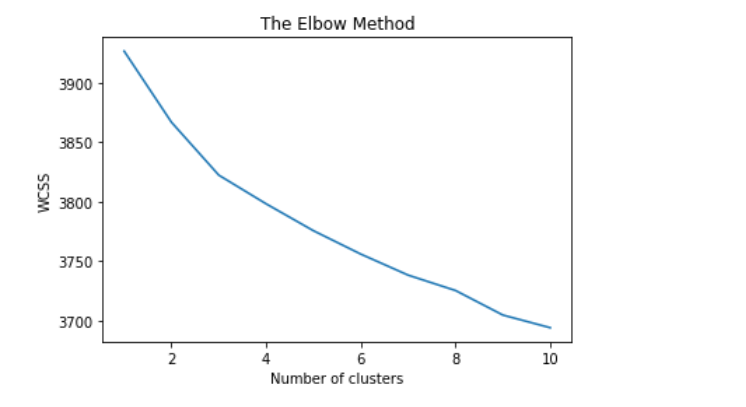

In [31]:
 from sklearn.cluster import KMeans
# wcss = []
# for i in range(1,11):
#     kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
#     kmeans.fit(X)
#     wcss.append(kmeans.inertia_)
# plt.plot(range(1,11),wcss)
# plt.title('The Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('WCSS')
# plt.show()

 #obtaining image of elbow curve as it takes a while to run
from IPython.display import Image, HTML, display
display(Image('elbow.PNG'))

In [32]:
print(words[250:300])

['anterior', 'anti', 'antibiot', 'antibodi', 'antifung', 'antigen', 'antihypertens', 'antimalari', 'antimicrobi', 'antipyresi', 'antisepsi', 'antisept', 'antisera', 'antithrombin', 'antivir', 'antivirus', 'anxieti', 'ap', 'apach', 'apart', 'apgar', 'apic', 'apoptosi', 'apoptot', 'appar', 'apparu', 'appeal', 'appear', 'appetit', 'appli', 'applic', 'appoint', 'appreci', 'approach', 'appropri', 'approv', 'approxim', 'apr', 'april', 'aptitud', 'ar', 'arabia', 'arabian', 'arbidol', 'arcgi', 'architectur', 'archiv', 'ard', 'area', 'areimport']


As more than one elbows have been generated, I will have to select right amount of clusters by trial and error. So, I will showcase the results of different amount of clusters to find out the right amount of clusters.

### 3 Clusters

In [33]:
kmeans = KMeans(n_clusters = 3, n_init = 20, n_jobs = 1) # n_init(number of iterations for clsutering) n_jobs(number of cpu cores to use)
kmeans.fit(X)
# We look at 3 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : covid, patient, case, clinic, diseas, china, ct, sever, wuhan, hospit, pneumonia, sar, coronavirus, day, symptom, infect, group, characterist, cov, confirm, fever, outbreak, novel, treatment, chest
1 : mer, cov, east, middl, respiratori, infect, patient, syndrom, case, coronavirus, saudi, arabia, mortal, sever, pneumonia, human, clinic, outbreak, virus, hospit, caus, diseas, report, influenza, viral
2 : sar, cov, virus, coronavirus, infect, protein, human, respiratori, patient, hcov, sever, detect, acut, cell, nl, viral, ncov, sequenc, genom, syndrom, pneumonia, sampl, use, caus, assay




0 : sar, cov, virus, coronavirus, infect, respiratori, human, protein, patient, hcov, sever, acut, detect, viral, cell, nl, syndrom, genom, sequenc, ncov, pneumonia, sampl, caus, use, assay
1 : covid, patient, case, clinic, diseas, china, ct, sever, wuhan, hospit, pneumonia, sar, coronavirus, day, infect, symptom, group, characterist, cov, confirm, novel, outbreak, transmiss, fever, treatment
2 : mer, cov, east, middl, respiratori, infect, patient, syndrom, case, saudi, coronavirus, arabia, mortal, pneumonia, sever, human, clinic, hospit, virus, influenza, report, caus, diseas, camel, outbreak

These 3 clusters can be interpreted as follows:
0: SARS. It is clear to me that this cluster is involving articles relating to SARS as "Severe" "Acute" and "Respiritory" and "syndrome" can all be see in the common words. Additionally, there are tags such as "sar: and 'cov' which are likely related to the full name for SARS 'SARS-CoV'

1: This is clearly grouping articles relatin to covid-19 as all of the tags are in realtion to China, Wuhan, novel with additional support to this claim from tags such as "cov" .

2: This is clearly relating to MERS as the tags "middle" ,'east', 'respiratory', 'syndrome' are all present which is further backed by "camel' as the virus was first identified in camel byproducts.

### 6 Clusters

In [34]:
# kmeans = KMeans(n_clusters = 6, n_init = 20, n_jobs = 1) # n_init(number of iterations for clsutering) n_jobs(number of cpu cores to use)
# kmeans.fit(X)
# # We look at 3 the clusters generated by k-means.
# common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
# for num, centroid in enumerate(common_words):
#     print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))### 6 Clusters


The 6 clusters do not help paint as clear a picture into grouping as the 3 clusters. There are some similarities with the bonus of having 0 containing the common coronaviruses seen with 'nl' 'oc' and 'hku', but there is too many categories with non valuable information  and the 3 clusters is very valuable.

0 : hcov, nl, hku, virus, human, coronavirus, influenza, oc, infect, respiratori, detect, genom, children, pcr, strain, assay, sequenc, adult, patient, tract, sampl, time, preval, real, common
1 : patient, covid, ct, clinic, group, sever, case, hospit, diseas, symptom, day, fever, chest, pneumonia, characterist, vs, critic, featur, admiss, sar, laboratori, age, lesion, studi, result
2 : mer, cov, east, middl, respiratori, infect, patient, syndrom, case, coronavirus, saudi, sever, pneumonia, arabia, mortal, human, clinic, outbreak, virus, sar, hospit, diseas, caus, report, viral
3 : cov, sar, protein, virus, ncov, coronavirus, cell, human, genom, sequenc, infect, ibv, bat, bind, viral, ace, structur, rna, host, gene, vaccin, receptor, respiratori, sever, activ
4 : sar, patient, cov, respiratori, acut, infect, sever, detect, sampl, syndrom, coronavirus, day, assay, case, clinic, diseas, control, pneumonia, test, viral, pcr, outbreak, ill, posit, use
5 : covid, case, china, patient, wuhan, diseas, transmiss, coronavirus, outbreak, estim, health, pneumonia, infect, number, sar, clinic, epidem, novel, provinc, confirm, spread, cov, public, data, ncov

### 9 Clusters

In [35]:
# kmeans = KMeans(n_clusters = 9, n_init = 20, n_jobs = 1) # n_init(number of iterations for clsutering) n_jobs(number of cpu cores to use)
# kmeans.fit(X)
# # We look at 3 the clusters generated by k-means.
# common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
# for num, centroid in enumerate(common_words):
#     print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))### 3 Clusters

The 9 clusters do not help paint as clear a picture into grouping as the 3 clusters. There are almost no similarities between terms that I can interpret.

0 : lung, mice, sar, cov, patholog, infect, cell, model, mer, marmoset, alveolar, inflammatori, anim, sever, human, ifn, acut, virus, respiratori, pathogenesi, viral, pneumonia, transgen, il, immun
1 : patient, covid, clinic, sever, hospit, diseas, group, case, sar, admiss, fever, symptom, characterist, day, critic, treatment, wuhan, age, laboratori, ci, lymphocyt, ill, studi, cov, level
2 : sar, covid, cov, coronavirus, china, spread, diseas, outbreak, health, respiratori, novel, world, infect, intern, case, wuhan, pneumonia, syndrom, countri, caus, decemb, emerg, sever, current, acut
3 : covid, case, china, patient, transmiss, estim, wuhan, outbreak, number, health, diseas, infect, provinc, coronavirus, pneumonia, confirm, epidem, public, clinic, sar, day, novel, data, hubei, epidemiolog
4 : mer, cov, east, middl, patient, respiratori, infect, syndrom, case, saudi, arabia, coronavirus, mortal, clinic, pneumonia, hospit, camel, report, human, outbreak, korea, present, sever, associ, rate
5 : protein, cov, sar, ncov, coronavirus, virus, genom, human, bat, ibv, sequenc, ace, vaccin, cell, structur, bind, rna, domain, receptor, viral, gene, infect, nsp, host, membran
6 : hcov, nl, virus, influenza, respiratori, infect, human, oc, coronavirus, detect, hku, children, tract, strain, pathogen, patient, adult, preval, pcr, common, genom, sampl, rhinovirus, viral, pilgrim
7 : sar, cov, patient, detect, respiratori, sampl, infect, assay, coronavirus, acut, sever, syndrom, virus, pcr, rt, test, day, control, use, elisa, pneumonia, antibodi, clinic, posit, ill
8 : ct, covid, patient, lesion, consolid, imag, chest, opac, pneumonia, featur, radiologist, ground, group, glass, score, distribut, ggo, comput, lung, lobe, clinic, vs, day, model, peripher

## Best Model

The model with the clusters that best alligned with my anticipated findings was the k=3 cluster model. This grouped the articles based on coronavirus type (MERS, SARS, Covid). This model will be used for the recommender system proposed.

In [36]:
def cluster_predict(str_input):
    Y = vectorizer.transform(str_input)
    prediction = kmeans.predict(Y)
    return prediction

In [37]:
# Create new column for storing predicted categories from our trained model.
virus['ClusterPrediction'] = ""

In [38]:

# Cluster category for each live course
virus['ClusterPrediction']=virus.apply(lambda x: cluster_predict(virus['abstract']), axis=0)


In [39]:
virus['ClusterPrediction'].unique()

array([2, 0, 1], dtype=int64)

## Recommendation System of Research Papers

Based on the clusters above a recommendation system waas created to help researchers, doctors, and scientists, expedite their resource retrieval process. Instead of sifting through thousands of articles they can use my system which will give them the most similar articles, likely on the same basis of virus they are investigating. For example, if someone is researching the MERS vaccinations and have a paper on it, using my recommendation system they can easily find other papers on the topic of MERS (the cluster) and likely terms matching vaccinations will help find them 10 papers that might superseed their investigation. 

To use the recommender they just have to enter the title of the current paper they are using, and 10 similar papers will be output. The recommender takes the corresponding abstract to the title and uses feeds it into the kmeans model to determine the distance to the closest cluster center. The top 10 articles closest to this point are recommended!

In [40]:
def recommend_util(str_input):
    
    # match on the basis course-id and form whole 'Description' entry out of it.
    temp_df = virus.loc[virus['title'] == str_input]
    temp_df['InputString'] = temp_df.abstract 
    str_input = list(temp_df['InputString'])
    print(str_input)
    # Predict category of input string category
    prediction_inp = cluster_predict(str_input)
    prediction_inp = int(prediction_inp)
    # Based on the above prediction 10 random courses are recommended from the whole data-frame
    # Recommendation Logic is kept super-simple for current implementation.
    temp_df = virus.loc[virus['ClusterPrediction'] == prediction_inp]
    temp_df = temp_df.sample(10)
    
    return list(temp_df['title'])

In [41]:

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)
#virus['title']

In [42]:
queries = ['genomic and protein structure modelling analysis depicts the origin and infectivity of 2019-ncov, a new coronavirus which caused a pneumonia outbreak in wuhan, china']
for query in queries:
    res = recommend_util(query)
    print(res)

['genomic and protein structure modelling analysis depicts the origin and infectivity of 2019-ncov, a new coronavirus which caused a pneumonia outbreak in wuhan, china abstractdetailed genomic and structure-based analysis of a new coronavirus, namely 2019-ncov, showed that the new virus is a new type of bat coronavirus and is genetically fairly distant from the human sars coronavirus. structure analysis of the spike (s) protein of this new virus showed that its s protein only binds weakly to the ace2 receptor on human cells whereas the human sars coronavirus exhibits strongly affinity to the ace receptor. these findings suggest that the new virus does not readily transmit between humans and should theoretically not able to cause very serious human infection. these data are important to guide design of infection control policy and inform the public on the nature of threat imposed by 2019-ncov when results of direct laboratory tests on this virus are not expected to be available in the n

C:\Users\Tyler\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
